In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
!pip install gurobipy
import gurobipy as grb
import os
import time

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 23.5 MB/s eta 0:00:00


In [2]:
f = scipy.io.loadmat('flow.mat')["flow"].reshape(28,)
C = scipy.io.loadmat('capacities.mat')["capacities"].reshape(28,)
B = scipy.io.loadmat('traffic.mat')["traffic"]
l = scipy.io.loadmat('traveltime.mat')["traveltime"].reshape(28,)


Text(0.5, 1.0, 'Highway network in Los Angeles ')

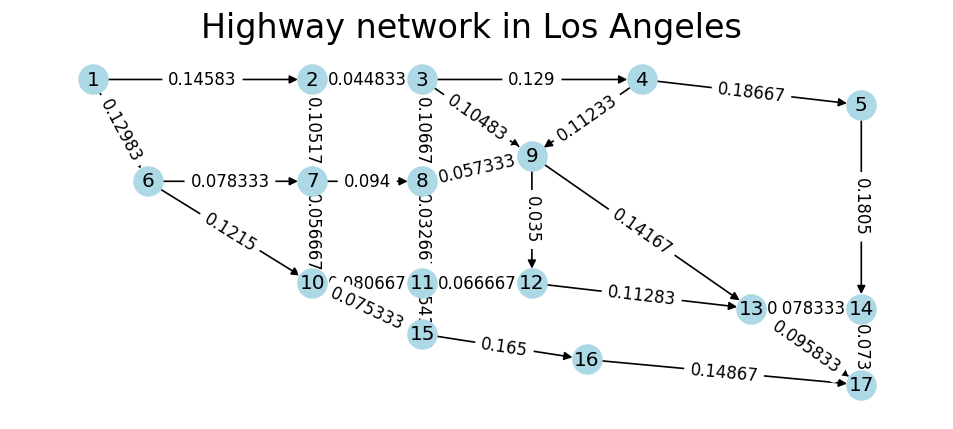

In [3]:
fig, ax = plt.subplots(figsize = (10,4), dpi=120)


n_edges = B.shape[1]
n_nodes = B.shape[0]

G = nx.DiGraph()
G.add_nodes_from(range(1,n_nodes+1))
edge_labels={}

for j in range(n_edges):
  for i in range(0,n_nodes):
    if(B[i][j] == 1):
      start = i + 1 # node i is the start of the edge. #The plus 1 is because we started from 1 in graph generation
    if(B[i][j] == -1):
      end = i + 1 # i don't like tail and head notation
  # inside the loop inside the edges
  G.add_edges_from([(start,end)])
  edge_labels[(start,end)] = str(l[j])
  G[start][end]['capacity'] = C[j]
  G[start][end]['weight'] = l[j]
pos = {1:[0,0], 2:[4,0], 3:[6,0], 4:[10,0], 5:[14, -1], 6:[1,-4], 7:[4,-4],8:[6,-4],9:[8, -3],
       10:[4, -8],11:[6, -8],12:[8, -8],13:[12, -9],14:[14, -9],15:[6, -10],16:[9, -11],17:[14, -12]}

nx.draw(G, pos, with_labels = True, node_color = 'lightblue')
nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)

ax.set_title("Highway network in Los Angeles ", fontsize=20)




In [4]:
#Defining external flow in the problem of Shortest Path
v = np.zeros(17)
v[0] = 1
v[16] = -1

In [5]:
model = grb.Model('gbpp')
f = model.addMVar(
    (n_edges,),
    vtype = grb.GRB.INTEGER,
    lb = 0,
    name = 'f'
)
edges = range(n_edges)
nodes = range(n_nodes)
expr = 0
#expr += grb.quicksum(l[e] * f[e] for e in edges)
expr += l @ f
model.setObjective(expr,grb.GRB.MINIMIZE)
model.addConstrs(
  #B[n][e] * f[e] == v[e] for e in range(n_edges) for n in range(n_nodes)
  #grb.quicksum(B[n,e] * f[e] for e in edges) == v[n]  for n in nodes
  B[n,:] @ f == v[n] for n in nodes
)

model.update()


#model.setParam('MIPgap', 0.01)
model.setParam(grb.GRB.Param.TimeLimit, 300)
model.setParam('OutputFlag', 1)
"""
model.setParam(
    'LogFile',os.path.join('.', 'logs', 'gurobi.log')
) # setting path in general way)
model.write(
    os.path.join('.', 'logs', "model.lp")
 )        # setting path in general way)
 """
start = time.time()
model.optimize()
end = time.time()
comp_time = end - start
print(f"computational time: {comp_time} s")

Restricted license - for non-production use only - expires 2024-10-28
Set parameter TimeLimit to value 300
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 17 rows, 28 columns and 56 nonzeros
Model fingerprint: 0x0689db14
Variable types: 0 continuous, 28 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-02, 2e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 0.6586590
Presolve removed 17 rows and 28 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 2 available processors)

Solution count 2: 0.532996 0.658659 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.329960000000e

In [6]:
optimal_f = []

for f in model.getVars():
    optimal_f.append(f.X)

optimal_f = np.array(optimal_f)

In [7]:
optimal_f

array([ 1.,  1.,  0., -0.,  0., -0., -0., -0.,  1., -0.,  0.,  1., -0.,
       -0.,  0., -0., -0., -0., -0., -0.,  0.,  0., -0., -0.,  1., -0.,
        0., -0.])

In [ ]:
np.argwhere(B[:,np.array(optimal_f, dtype = bool)] != 0).transpose()[0] + 1

array([ 1,  2,  2,  3,  3,  9,  9, 13, 13, 17])

In [ ]:
np.argwhere(B[:,1] !=0).ravel()

array([1, 2])

In [ ]:
nx.shortest_path(G,1,17)

[1, 2, 3, 9, 13, 17]

In [ ]:
nx.maximum_flow(G,1,17)

(22448,
 {1: {2: 8741, 6: 13707},
  2: {3: 8741, 7: 0},
  3: {4: 0, 8: 0, 9: 8741},
  4: {5: 0, 9: 0},
  5: {14: 0},
  6: {7: 4624, 10: 9083},
  7: {8: 4624, 10: 0},
  8: {9: 4624, 11: 0},
  9: {13: 6297, 12: 7068},
  10: {11: 825, 15: 8258},
  11: {12: 825, 15: 0},
  12: {13: 7893},
  13: {14: 3835, 17: 10355},
  14: {17: 3835},
  15: {16: 8258},
  16: {17: 8258},
  17: {}})

In [ ]:
nx.algorithms.flow.maximum_flow(G,1,17)

(22448,
 {1: {2: 8741, 6: 13707},
  2: {3: 8741, 7: 0},
  3: {4: 0, 8: 0, 9: 8741},
  4: {5: 0, 9: 0},
  5: {14: 0},
  6: {7: 4624, 10: 9083},
  7: {8: 4624, 10: 0},
  8: {9: 4624, 11: 0},
  9: {13: 6297, 12: 7068},
  10: {11: 825, 15: 8258},
  11: {12: 825, 15: 0},
  12: {13: 7893},
  13: {14: 3835, 17: 10355},
  14: {17: 3835},
  15: {16: 8258},
  16: {17: 8258},
  17: {}})

In [8]:
#Finding exogenous flow given by the flow defined in the file
f = scipy.io.loadmat('flow.mat')["flow"].reshape(28,)

v = B @ f

In [9]:
v[1:] = 0
v[16] = -v[0]

In [25]:
v

array([ 16282,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
       -16282], dtype=int32)

In [99]:
model = grb.Model('gbpp')
model.params.NonConvex = 2
f = model.addVars(
    n_edges,
    vtype = grb.GRB.CONTINUOUS,
    lb = 0,
    name = 'f'
)
z = model.addVars(
    n_edges,
    vtype = grb.GRB.CONTINUOUS,
    lb = 0,
    name = 'z'
)
edges = range(n_edges)
nodes = range(n_nodes)
expr = -1*sum(
    l[e] * C[e] for e in edges
)
expr += grb.quicksum(
(l[e] * C[e]) * z[e] for e in edges
)

model.setObjective(expr,grb.GRB.MINIMIZE)
model.update()

model.addConstrs(
  grb.quicksum(B[n,e] * f[e] for e in edges) == v[n]  for n in nodes
)
model.addConstrs(
    (1 - f[e] / C[e]) * z[e] == 1 for e in edges
)
model.addConstrs(
    f[e] <= C[e] for e in edges
)

model.setParam('OutputFlag', 1)

start = time.time()
model.optimize()
end = time.time()
comp_time = end - start
print(f"computational time: {comp_time} s")

Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 45 rows, 56 columns and 84 nonzeros
Model fingerprint: 0x67eb6236
Model has 28 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [7e-05, 2e-04]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [4e+02, 2e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+03, 2e+04]
  QRHS range       [1e+00, 1e+00]
Presolve removed 29 rows and 0 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 30 rows and 2 columns
Presolve time: 0.00s
Presolved: 127 rows, 55 columns, 225 nonzeros
Presolved model has 28 bilinear constraint(s)
Variable types: 55 continuous, 0 integer (0 binary)

Root relaxation: objective 1.187721e+04, 48 iterations, 0.00 seconds (0

In [90]:
model = grb.Model('gbpp')
#model.params.NonConvex = 2
f = model.addMVar(
    (n_edges,),
    vtype = grb.GRB.CONTINUOUS,
    lb = 0,
    name = 'f'
)

edges = range(n_edges)
nodes = range(n_nodes)

expr = 0
expr += (1- f @ (1/C)) / (l @ C)


model.setObjective(expr,grb.GRB.MAXIMIZE)
model.update()

model.addConstrs(
  grb.quicksum(B[n,e] * f[e] for e in edges) == v[n]  for n in nodes
)
model.addConstrs(
    f[e] <= C[e] for e in edges
)
model.addConstrs(
    (1 - f[e]/C[e] >= 0.0000001) for e in edges
)


model.setParam('OutputFlag', 1)

start = time.time()
model.optimize()
end = time.time()
comp_time = end - start
print(f"computational time: {comp_time} s")

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 73 rows, 28 columns and 112 nonzeros
Model fingerprint: 0xf0a2e78c
Coefficient statistics:
  Matrix range     [7e-05, 1e+00]
  Objective range  [3e-09, 6e-09]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+04]
Presolve removed 62 rows and 5 columns
Presolve time: 0.01s
Presolved: 11 rows, 23 columns, 40 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8014767e-05   5.136375e+03   0.000000e+00      0s
      16   -2.7406669e-04   0.000000e+00   0.000000e+00      0s

Solved in 16 iterations and 0.01 seconds (0.00 work units)
Optimal objective -2.740666858e-04
computational time: 0.03194475173950195 s


In [100]:
optimal_f = []

for f in model.getVars():
    optimal_f.append(f.X)

optimal_f = np.array(optimal_f)

In [101]:
optimal_f

array([6.45411896e+03, 5.91941601e+03, 2.99529135e+03, 2.99529135e+03,
       9.82788104e+03, 4.49706786e+03, 2.89742390e+03, 2.43597281e+03,
       3.04732963e+03, 5.34702942e+02, 1.93640504e-07, 2.92412467e+03,
       3.63272896e-08, 2.99529135e+03, 5.33081319e+03, 2.73085943e+03,
       4.73430066e+03, 2.13434690e+03, 4.61451087e+02, 2.31276785e+03,
       3.19231051e+03, 5.50507836e+03, 2.31052796e+03, 4.62167448e-08,
       6.24188003e+03, 5.30581931e+03, 4.73430066e+03, 4.73430066e+03,
       3.82223641e+00, 2.50064393e+00, 1.28926853e+00, 1.37768269e+00,
       3.53353433e+00, 2.82590002e+00, 1.64037466e+00, 1.57424734e+00,
       1.93773499e+00, 1.05059978e+00, 1.00000000e+00, 1.48365613e+00,
       1.00000000e+00, 1.44548203e+00, 2.42072169e+00, 1.58287673e+00,
       1.54930570e+00, 1.23501744e+00, 1.04400829e+00, 1.30011656e+00,
       1.57626163e+00, 2.04700654e+00, 1.52915212e+00, 1.00000000e+00,
       2.51755360e+00, 2.41067918e+00, 1.65249405e+00, 2.34355977e+00])

In [95]:
C

array([ 8741,  9864, 13350, 10926, 13707,  6960,  7422,  6678,  6297,
       11102,  8899,  8970,  9753,  9719,  9083,  7416, 13353, 11216,
       10947, 10019,  8732, 10763,  6677,  9403, 10355,  9067, 11990,
        8258], dtype=uint16)

In [77]:
optimal_f[0]

8740.9991259

In [78]:
optimal_f[4]

7541.0008741

In [28]:
8741 + 7541

16282

In [29]:
6.64219910e+03 + 1.01638009e+04

16806.0

In [31]:
vect_sol = [6.64219910e+03 ,6.05893789e+03, 3.13232779e+03, 3.13232589e+03,
 1.01638009e+04, 4.63831664e+03 ,3.00634073e+03 ,2.54263460e+03,
 3.13154448e+03, 5.83261212e+02 ,1.45164550e-02 ,2.92659559e+03,
1.89781986e-03 ,3.13232589e+03 ,5.52548426e+03, 2.85427264e+03,
 4.88644874e+03, 2.21523712e+03, 4.63720641e+02, 2.33768761e+03,
 3.31799129e+03 ,5.65567890e+03 ,2.37310712e+03, 1.99567283e-03,
 6.41411626e+03, 5.50543301e+03, 4.88645073e+03, 4.88645073e+03]

In [79]:
tmp = 0
for e in edges:
  tmp += (l[e] * C[e]) / (1-optimal_f[e]/C[e]) - l[e] * C[e]

In [80]:
tmp

24181309294.7834

In [93]:
tmp2 = np.zeros(n_nodes)
for i in nodes:
  for j in edges:
    tmp2[i] += B[i,j] * optimal_f[j]

In [94]:
tmp2

array([ 16282.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0., -16282.])